This uses the [(Generic) EfficientNets for PyTorch](https://github.com/rwightman/gen-efficientnet-pytorch) repo.

In [1]:
from pathlib import Path
from typing import List, Tuple, Callable

from fastai.vision import *
from torch import nn
import torch
import geffnet

In [2]:
PROJECT_ROOT = Path('.').absolute().parents[0]
DATA_FOLDER = PROJECT_ROOT / 'data' / 'processed'
TRAIN_CSV = DATA_FOLDER / 'train.csv'
VALID_CSV = DATA_FOLDER / 'valid.csv'
CARS_FOLDER = DATA_FOLDER / 'car_data'

MODEL_NAME = 'tf_efficientnet_b2_ap' # best model with sub 10m parameters
IMAGE_SIZE = 260
BATCH_SIZE = 16 # 3539MiB for lr_find / 3557MiB for fit_fc

In [3]:
data = (
    ImageList.from_folder(CARS_FOLDER/'train')
        .split_by_rand_pct(0.1)
        .label_from_folder()
        .transform(tfms=get_transforms(), size=IMAGE_SIZE)
        .databunch(bs=BATCH_SIZE)
        .normalize(imagenet_stats)
)

In [4]:
def make(pretrained):
    return geffnet.tf_efficientnet_b2_ap(pretrained=pretrained, drop_rate=0.25, drop_connect_rate=0.2, as_sequential=True).train()

In [5]:
learner = cnn_learner(data, make, metrics=[accuracy])

In [6]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.25E-03
Min loss divided by 10: 1.58E-03


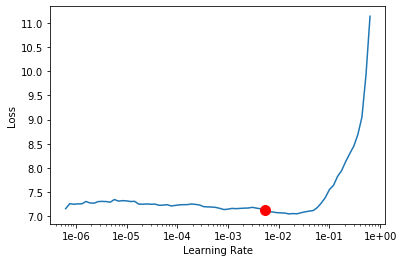

In [7]:
learner.recorder.plot(suggestion=True)

In [8]:
learner.fit_fc(4, lr=3e-3)

This is a wild success compared to the last one.
It loads into the cnn_learner without issue, it trains in 1/3rd of the time and gets 68x better results.
To be fair this is equivalent to b2 when the last model I trained was b3 (which may account for the speed difference).
Even so this looks far more reasonable.

I now want to train this substantially to see where it tops out.
For imagenet this is reported at [80.306 top 1 / 95.028 top 5](https://github.com/rwightman/gen-efficientnet-pytorch#ported-weights) so getting to near 80% would be good.

In [9]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.75E-06
Min loss divided by 10: 5.25E-06


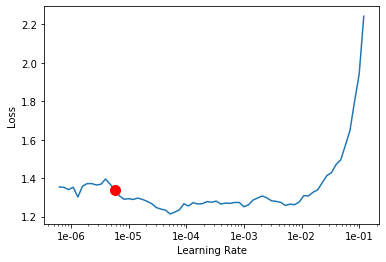

In [10]:
learner.recorder.plot(suggestion=True)

In [12]:
learner.fit_fc(20, lr=3e-3) # this still has the same optimizer problem - is that a bug with the optimizer?

In [13]:
learner.save('20e-tf_efficientnet_b2_ap-cars')

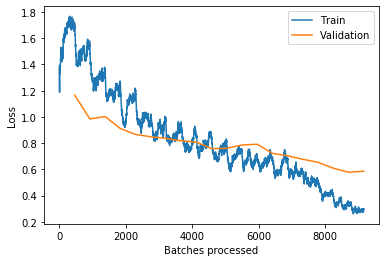

In [14]:
learner.recorder.plot_losses()

In [15]:
learner.recorder.plot_lr()

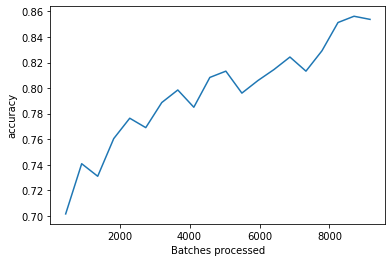

In [16]:
learner.recorder.plot_metrics()

So this has exceeded my expectations!
It looks like it could train further as well.
I don't think training this for longer is that important - I've demonstrated that this repo works well and I'm keen to apply it to the problem of interest.